In [13]:
import plumed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from SCRIPTS.func_block import read_fes_3d


In [14]:
FOLDER = 'S5-S6_adapted-CA/mw_0.8' #'S5-S6_adapted-MG/mw_0.8'#'S5-S6_adapted-CA/mw_0.85'#'System.0.MGb_bc/METAD.3D.b5h0.3'
BIASF = 5
RESI=489
CV=['cn', 'd_580', 'd_489']

DT=50
CV_new = ['ch1', 'ch2']
BINS_new = [120, 120]
RANGE_new = [-180, 180, -180, 180]
N_walkers = 4
kBT=310*8.314462618*0.001


# 1. Создаем df - таблицу с CV (d_489, d_580, cn) и значениями углов в те же моменты времени

In [15]:
cols = ['d_489', 'd_580', 'cn', 'ch1', 'ch2']
df_CV = pd.DataFrame(columns=cols)
for w in range(N_walkers):
    COLVARw = plumed.read_as_pandas(f'{FOLDER}/walker_{w}/COLVAR.{w}')

    CH1 = pd.read_csv(f'{FOLDER}/walker_{w}/dihedral/ch1_{RESI}_gp t_0--1 dt_{DT}.csv', 
                            header = None, names = ['t', 'ch1'])
    CH2 = pd.read_csv(f'{FOLDER}/walker_{w}/dihedral/ch2_{RESI}_gp t_0--1 dt_{DT}.csv', 
                            header = None, names = ['t', 'ch2'])
    df_full = COLVARw[COLVARw['time']%DT==0].merge(CH1, left_on='time', right_on='t').merge(CH2, left_on='time', right_on='t')
    df_CV = pd.concat([df_CV, df_full[cols]])
df_CV

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++
/tmp/ipykernel_1349100/572500653.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  COLVARw = plumed.read_as_pandas(f'{FOLDER}/walker_{w}/COLVAR.{w}')
/tmp/ipykernel_1349100/572500653.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_CV = pd.concat([df_CV, df_full[cols]])
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++
/tmp/ipykernel_1349100/572500653.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecate

,d_489,d_580,cn,ch1,ch2
0,0.347238,0.293082,3.878851,-51.9505,-106.9850
1,0.278595,0.298337,4.148552,-51.4529,-92.3914
2,0.290396,0.340713,4.318452,-50.1732,-83.0220
3,0.332509,0.346604,4.788400,-51.8587,135.6290
4,0.343129,0.353008,3.877453,-59.5940,111.6150
...,...,...,...,...,...
6223,1.060392,1.254203,7.865160,-46.4183,98.4817
6224,1.164530,1.405642,6.644318,-55.2611,87.9395
6225,1.521602,1.816534,7.713695,-60.5073,107.8510
6226,1.752403,1.869141,8.007027,-57.0346,101.6720


In [16]:
103088*50/(4*1e6)

1.2886

# 2. 

In [17]:
dist1, dist2, cn, fes, Nbins_D1, Nbins_D2, Nbins_CN, Bonds_D1, Bonds_D2, Bonds_CN = read_fes_3d(FOLDER)
fes -= np.max(fes)

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++
/home/veretenenko/TRPV6-Mg/ScaledTopology-final/SCRIPTS/func_block.py:206: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = plumed.read_as_pandas(f"{FOLDER}/FES/{NAME}.dat")


232 235 210 [0.0758954, 4.15059] [0.0758448, 4.2035] [1.71578, 9.10359]


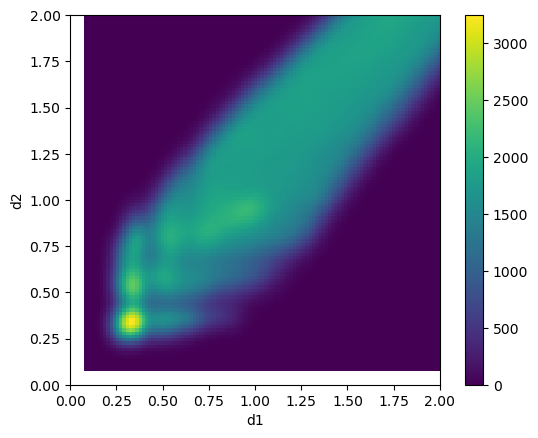

(0.0, 2.0)

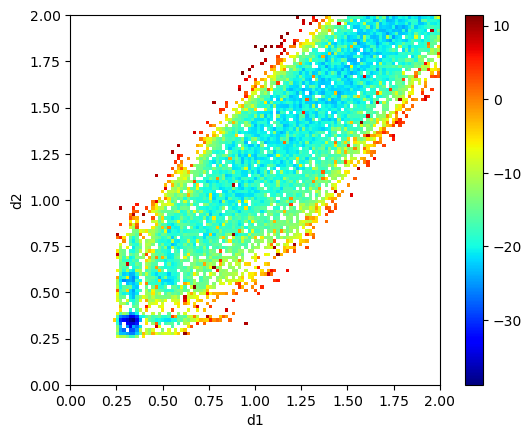

In [18]:
Ubias = -fes * (1-1/BIASF)

WEIGHTS_CV, ED_CV = np.histogramdd(df_CV[['cn', 'd_580', 'd_489']].to_numpy(), 
                            bins = [Nbins_CN, Nbins_D2, Nbins_D1],
                            range = (Bonds_CN, Bonds_D2, Bonds_D1),
                            density=True, 
                            )
h = plt.imshow(np.sum(Ubias, axis=0).T, 
           extent = [ED_CV[2][0], ED_CV[2][-1], ED_CV[1][0], ED_CV[1][-1]],
           aspect='equal',
        origin='lower',
           interpolation=None)
plt.colorbar(h)
plt.xlabel('d1')
plt.ylabel('d2')
plt.title('')
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.show()

weighted_avg = np.sum(np.exp(1/kBT * Ubias) * WEIGHTS_CV, axis=0)
weighted_avg[weighted_avg==0]=np.nan
norm = np.sum(np.exp(1/kBT * (Ubias-np.max(Ubias))))
fes_dens = -kBT * np.log(weighted_avg/norm)

h = plt.imshow(fes_dens.T, 
           extent = [ED_CV[2][0], ED_CV[2][-1], ED_CV[1][0], ED_CV[1][-1]],
           aspect='equal',
        origin='lower',
        cmap='jet',
           interpolation=None)
plt.colorbar(h)
plt.xlabel('d1')
plt.ylabel('d2')
plt.title('')
plt.xlim(0, 2)
plt.ylim(0, 2)

Text(0.5, 1.0, 'Weights ch1-ch2')

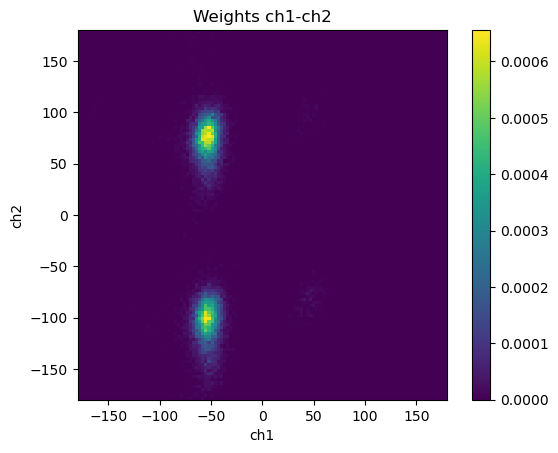

In [19]:
WEIGHTS_new, ED_new = np.histogramdd(df_CV[CV_new].to_numpy(), #[tstart:tfinal], 
                            bins = BINS_new,
                            range = [RANGE_new[:2], RANGE_new[2:]],
                            density=True, 
                            )

h = plt.imshow(WEIGHTS_new.T, 
           extent = RANGE_new,
           aspect='equal',
           interpolation=None)
plt.colorbar(h)
plt.xlabel(CV_new[0])
plt.ylabel(CV_new[1])
plt.title(f'Weights {CV_new[0]}-{CV_new[1]}')

In [20]:
I_cn = np.searchsorted(ED_CV[0], df_CV['cn'], side='left') - 1
I_d2 = np.searchsorted(ED_CV[1], df_CV['d_580'], side='left') - 1
I_d1 = np.searchsorted(ED_CV[2], df_CV['d_489'], side='left') - 1

I_new2 = np.searchsorted(ED_new[1], df_CV[CV_new[1]], side='left') - 1
I_new1 = np.searchsorted(ED_new[0], df_CV[CV_new[0]], side='left') - 1

Text(0.5, 1.0, 'Ubias ch1-ch2')

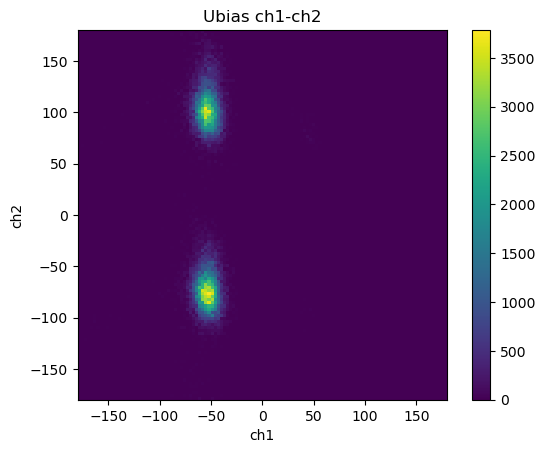

In [21]:
Ubias = -fes * (1-1/BIASF)

Ubias_new = np.zeros(BINS_new)

for t in range(df_CV.shape[0]):
    Ubias_new[I_new1[t], I_new2[t]] += Ubias[I_cn[t], I_d2[t], I_d1[t]]

h = plt.imshow(Ubias_new.T, 
           extent = RANGE_new,
           aspect='equal',
           interpolation=None, 
           origin='lower'
           )
plt.colorbar(h)
plt.xlabel(CV_new[0])
plt.ylabel(CV_new[1])
plt.title(f'Ubias {CV_new[0]}-{CV_new[1]}')

/tmp/ipykernel_1349100/3490882690.py:7: RuntimeWarning: overflow encountered in exp
  weighted_avg = np.exp(1/kBT * (Ubias_new)) * WEIGHTS_new


Text(0.5, 1.0, 'S5-S6_adapted-CA/mw_0.8 FES ch1-ch2, resi 489')

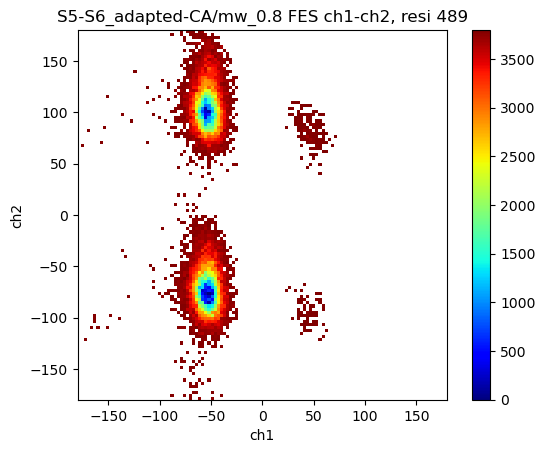

In [22]:
WEIGHTS_new[WEIGHTS_new==0] = np.nan
# Ubias_new -= np.nanmax(Ubias_new)
# fes_dens = -kBT * np.log(WEIGHTS_new) - Ubias_new + kBT * scipy.special.logsumexp((Ubias_new)/kBT)
# fes_dens -= np.nanmin(fes_dens)


weighted_avg = np.exp(1/kBT * (Ubias_new)) * WEIGHTS_new
# weighted_avg[weighted_avg==0]=np.nan

# norm = np.sum(np.exp(1/kBT * (Ubias-np.max(Ubias))))

# fes_dens = -kBT * np.log(weighted_avg/norm)

norm = scipy.special.logsumexp(1/kBT * (Ubias_new))
fes_dens = -kBT * (np.log(WEIGHTS_new) + Ubias_new/kBT  - norm)
fes_dens -= np.nanmin(fes_dens[fes_dens>-np.inf])

h = plt.imshow(fes_dens.T, 
           extent = RANGE_new,
           aspect='equal',
           interpolation=None, 
           cmap='jet',
           origin = 'lower',
        #    vmax=1200
           )
plt.colorbar(h)
plt.xlabel(CV_new[0])
plt.ylabel(CV_new[1])
plt.title(f'{FOLDER} FES {CV_new[0]}-{CV_new[1]}, resi {RESI}')
# plt.savefig(f'{FOLDER}/reweight_{CV_new[0]}-{CV_new[1]}_{RESI}.svg', dpi=300, bbox_inches = 'tight')

In [23]:
np.nansum(np.exp(Ubias_new * WEIGHTS_new / kBT))

np.float64(1588.8851381386323)

In [24]:
Ubias_new/kBT

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(120, 120))